# Nevus segmentation

---

## About the dataset

The images have been taken from [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html). These are photographs of two types of **skin lesions:** melanoma and moles. They will not be classifieed, but segmented.
Here is the example of the original image and its segmentation:

<table><tr><td>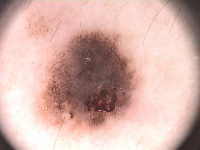</td><td>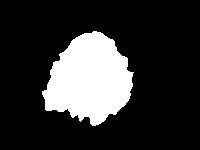</td></tr></table>

## Libraries

In [1]:
!pip install googledrivedownloader
!pip install patool

     |████████████████████████████████| 77 kB 3.1 MB/s 


In [2]:
# Dowloading folder with images
from google_drive_downloader import GoogleDriveDownloader as gdd
import patoolib
import os

# Working with images
from skimage.io import imread, imshow
from skimage.transform import resize

# Plotting
from matplotlib import pyplot as plt
from matplotlib import rcParams
from IPython import display

# Working with arrays
import numpy as np

# PyTorch
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

## 1. Data preparation

### Downloading and unraring data

In [3]:
# Downloading data from Google drive
gdd.download_file_from_google_drive(file_id='1VtEDXKLJSe0-x3RnQvlvZZv9bqKMte0h',
                                    dest_path='./PH2Dataset.rar',
                                    unzip=False)

In [4]:
# Extraction from archive
patoolib.extract_archive("PH2Dataset.rar")

patool: Extracting PH2Dataset.rar ...
patool: running /usr/bin/unrar x -- /content/PH2Dataset.rar
patool:     with cwd='./Unpack_n0rw9l2u'
patool: ... PH2Dataset.rar extracted to `PH2Dataset'.


'PH2Dataset'

Dataset structure:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

`X.bmp` — original image for segmentation, `X_lesion.bmp` — segmentation result.

Original and segmentated images from folder are extracted and added do images and lesions lists.

In [5]:
images = []
lesions = []
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

The first image and its segmentation.

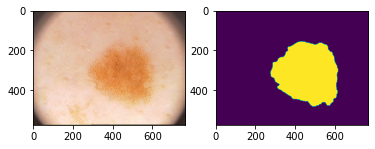

In [6]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(images[0])
ax[1].imshow(lesions[0])
plt.show()

### Data transformation

Images have different sizes. Let's resize them to $256\times256$ pixels. This function also automatically normalizes images in the $[0,1]$ range.

In [7]:
size = (256, 256)

# It is crucial to useGaussian filter when resizing the image to avoid aliasing artifacts.
X = [resize(x, size, mode='constant', anti_aliasing=True) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [8]:
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


Checking if everything is correct.

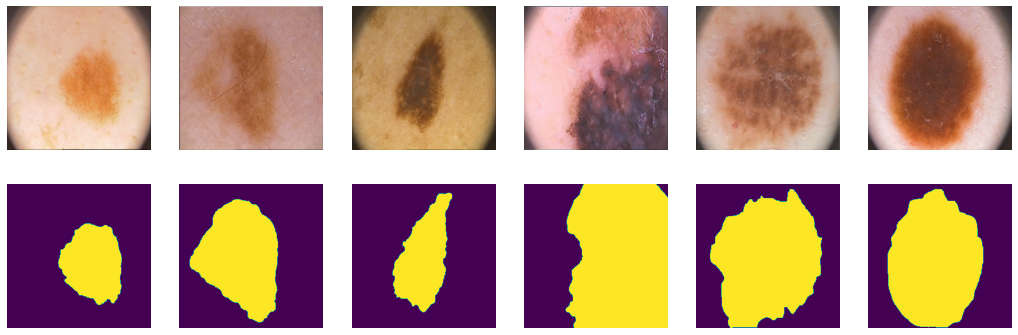

In [9]:
plt.figure(figsize=(18, 6))

for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show()

Our 200 images will be divided into train, validation and test in the proportion of 100/50/50.

In [10]:
ix = np.random.choice(len(X), size=len(X), replace=False)
tr, val, ts = np.split(ix, [100, 150])

In [11]:
print(len(tr), len(val), len(ts))

100 50 50


### Loading data in PyTorch DataLoader

In [12]:
batch_size = 25

# np.rollaxis - Roll the specified axis backwards, until it lies in a given position. From (100, 256, 256, 3) --> (100, 3, 256, 256).
# np.newaxis - Increase the dimension of the existing array by one. From (100, 256, 256) --> (100, 1, 256, 256).


data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, start=1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, start=1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, start=1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=False)

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## 2. Different architectures

Several neural network architectures will be tested for semantic segmentation problem. They are compared in terms of quality on the test and with different loss functions for them.

-----------------------------------------------------------------------------------------

### a) SegNet

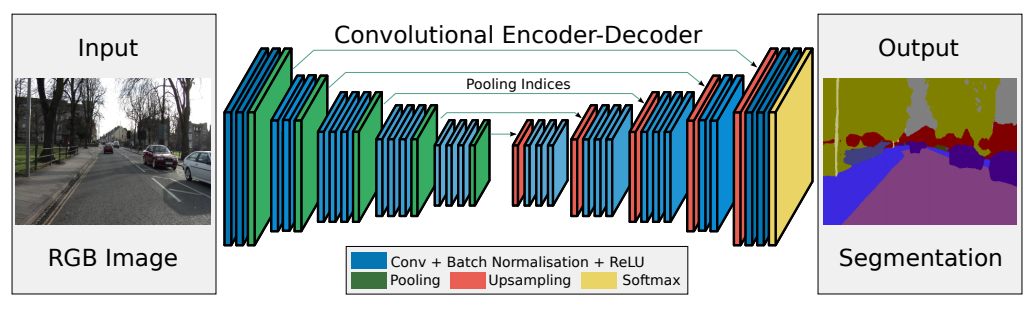

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

**Simple deconvolution network.**

In [14]:
# All rc (runtime config) settings are stored in a dictionary-like variable called matplotlib.rcParams, which is global to the matplotlib package.
rcParams['figure.figsize'] = (15,4)

In [15]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        
        # out_channels - number of filters
        # in_channels - Number of channels in the input image
        
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)  # 256 -> 128
        
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 128 -> 64

        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.pool2 =  nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 64 -> 32

        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.pool3 =  nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 32 -> 16

        # bottleneck
        # self.bottleneck_conv = nn.Conv2d(512, 512, kernel_size=3, padding=1)

        # decoder (upsampling)
        self.upsample0 = nn.MaxUnpool2d(kernel_size=2, stride=2) # 16 -> 32
        self.dec_conv0 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()            
        )

        self.upsample1 = nn.MaxUnpool2d(kernel_size=2, stride=2) # 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()   
        )

        self.upsample2 = nn.MaxUnpool2d(kernel_size=2, stride=2) # 32 -> 64
        self.dec_conv2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()   
        )

        self.upsample3 = nn.MaxUnpool2d(kernel_size=2, stride=2) # 32 -> 64
        self.dec_conv3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=1, kernel_size=3, padding=1),
            nn.BatchNorm2d(1),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=1, out_channels=1, kernel_size=3, padding=1),
            nn.BatchNorm2d(1),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=1, out_channels=1, kernel_size=3, padding=1),
            nn.BatchNorm2d(1),
            nn.ReLU()   
        )

    def forward(self, x):
        # encoder
        e0, idx0 = self.pool0(self.enc_conv0(x))
        e1, idx1 = self.pool1(self.enc_conv1(e0))
        e2, idx2 = self.pool2(self.enc_conv2(e1))
        e3, idx3 = self.pool3(self.enc_conv3(e2))

        # bottleneck
        # b = self.bottleneck_conv(e3)

        # decoder
        d0 = self.dec_conv0(self.upsample0(e3, idx3))
        d1 = self.dec_conv1(self.upsample1(d0, idx2))
        d2 = self.dec_conv2(self.upsample2(d1, idx1))
        d3 = self.dec_conv3(self.upsample3(d2, idx0))  # no activation

        return d3

### Metrics

The first one can be Jaccard similarity:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

In [16]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape

    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))
    union = (outputs | labels).float().sum((1, 2)) 
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10 
    
    return thresholded 

### Loss function

Binary cross-entropy can be used:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

, but $\lim_{x\rightarrow0}\log(x)=\infty$ leads to instability in the optimization process.Thus, modification is used.

In [17]:
def bce_loss(y_real, y_pred):
    # y_pred - logits
    # y_real - labels
    zeros = torch.zeros(size=y_pred.shape).to(device)
    loss = torch.mean(torch.max(y_pred, zeros) - y_pred * y_real + torch.log(1 + torch.exp(-abs(y_pred))))
    return loss

### Training cycle

In [19]:
def train(model, opt, loss_fn, epochs, data_tr, data_val, visual=False):

    X_val, Y_val = next(iter(data_val))
    train_losses, val_losses = [], []

    for epoch in range(epochs):
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0

        # train mode
        model.train()
        
        for X_batch, Y_batch in data_tr:
            # data to device
            X_batch=X_batch.to(device)
            Y_batch=Y_batch.to(device)
            # set parameter gradients to zero
            opt.zero_grad()
            # forward
            Y_pred = model(X_batch)
            # loss
            loss = loss_fn(Y_batch,Y_pred) 
            loss.backward()  # backward-pass
            opt.step()  # update weights

            # calculate loss to show the user
            avg_loss += loss / len(Y_batch)
            
        train_losses.append(avg_loss)
        print('Average train loss: %f' % avg_loss)

        # testing mode
        model.eval()  
        logits = model(X_val.to(device))
        probabilities = torch.sigmoid(logits)
        preds = (probabilities>0.5).type(torch.long)
        Y_hat = preds.cpu().detach()
        loss_val = loss_fn(Y_val.to(device),logits)
        val_losses.append(loss_val)
        print('Average validation loss: %f' % loss_val)
        
        # Visualize tools
        if visual:
            display.clear_output(wait=True)
            for k in range(6):
                plt.subplot(2, 6, k+1)
                plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
                plt.title('Real')
                plt.axis('off')

                plt.subplot(2, 6, k+7)
                plt.imshow(Y_hat[k, 0], cmap='gray')
                plt.title('Output')
                plt.axis('off')
            plt.show()

    plt.figure(figsize=(10,7))
    plt.plot(range(epochs), train_losses, xlab="Epoch", ylab="Train loss")
    plt.plot(range(epochs), val_losses, xlab="Epoch", ylab="Validation loss")
    plt.show()

### Testing on new data with Jaccard similarity

In [20]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    for X_batch, Y_label in data:
        X_batch = X_batch.to(device)
        Y_pred = model(X_batch)
        probs = torch.sigmoid(Y_pred)
        preds = (probs>0.5).type(torch.long)
        scores += metric(preds, Y_label).mean().item()

    return scores/len(data)

### Training on the data

In [ ]:
torch.cuda.empty_cache()

In [21]:
model = SegNet().to(device)

In [23]:
max_epochs = 20
optim = torch.optim.Adam(model.parameters())
train(model, optim, bce_loss, max_epochs, data_tr, data_val)

In [ ]:
score_model(model, iou_pytorch, data_val)

### Additional loss function

1. Dice loss


$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

This function is not differentiable, but it is a necessary property for gradient descent. In this case, we can approximate it with:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \sum_i\frac{2X_iY_i}{X_i+Y_i}.$$


In [24]:
def dice_loss(y_real, y_pred):
    probs = torch.sigmoid(y_pred)

    smooth = 1

    targets = y_real.view(-1)
    inputs = probs.view(-1)
    
    intersection = (inputs * targets).sum()                            
    dice =  (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
    
    return 1 - dice

Training with dice loss:

In [ ]:
model_dice = SegNet().to(device)

max_epochs = 40
optimaizer = optim.Adam(model_dice.parameters())
train(model_dice, optimaizer, dice_loss, max_epochs, data_tr, data_val)

In [ ]:
score_model(model_dice, iou_pytorch, data_val)

2. **Focal loss**

BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

The problem with this loss is that it tends to benefit the **majority** class over the **minority** class. Therefore, weighting factors are usually applied to each class:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

The weight $\alpha_i$ is defined as the reciprocal frequency of that pixel's class $i$, so that minority class observations weigh more relative to the majority class.

Another addition is the weighted pixel option, which weights each pixel by the degree of confidence we have in predicting that pixel.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$
Let's $\gamma=2$.


In [25]:
def focal_loss(y_real, y_pred, eps = 1e-8, gamma = 2):
    probs = torch.sigmoid(y_pred)

    targets = y_real.view(-1)
    inputs = probs.view(-1)

    fraction_1 = torch.count_nonzero(targets)
    fraction_0 = targets.shape[0] - fraction_1

    if fraction_1 >= fraction_0:
      alpha = 1 - fraction_0/targets.shape[0]
    else:
      alpha = 1 - fraction_1/targets.shape[0]
    
    BCE = bce_loss(y_real, y_pred)
    BCE_EXP = torch.exp(-BCE)
    focal_loss = alpha * (1-BCE_EXP)**gamma * BCE
                    
    return focal_loss

Training with focal loss:

In [ ]:
model_focal = SegNet().to(device)

max_epochs = 40
optimaizer = optim.Adam(model_focal.parameters())
train(model_focal, optimaizer, focal_loss, max_epochs, data_tr, data_val)

In [ ]:
score_model(model_focal, iou_pytorch, data_val)

### b) U-Net

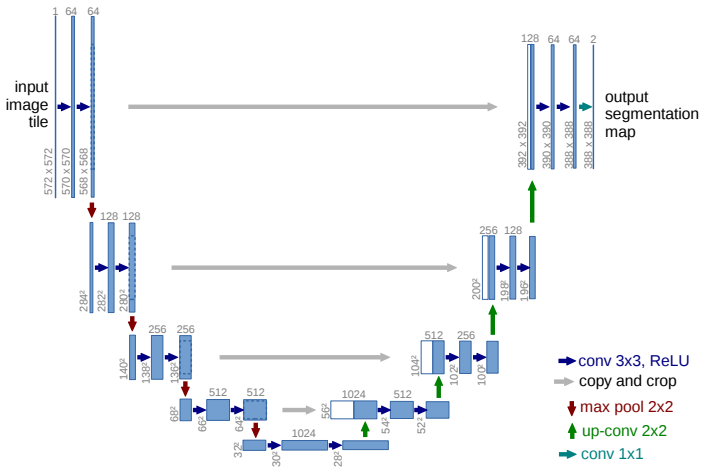

Encoder and decoder are still used in **SegNet**, also *skip-conenctions* are implemented.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [26]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.enc_conv0 = nn.Sequential(nn.Conv2d(3, 64, kernel_size=3),
                                        nn.BatchNorm2d(64),
                                        nn.ReLU(),
                                        nn.Conv2d(64, 64, kernel_size=3),
                                        nn.BatchNorm2d(64),
                                        nn.ReLU())
        
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.enc_conv1 = nn.Sequential(nn.Conv2d(64, 128, kernel_size=3),
                                        nn.BatchNorm2d(128),
                                        nn.ReLU(),
                                        nn.Conv2d(128, 128, kernel_size=3),
                                        nn.BatchNorm2d(128),
                                        nn.ReLU())
        
        self.pool1 =  nn.MaxPool2d(kernel_size=2, stride=2) 

        self.enc_conv2 = nn.Sequential(nn.Conv2d(128, 256, kernel_size=3),
                                        nn.BatchNorm2d(256),
                                        nn.ReLU(),
                                        nn.Conv2d(256, 256, kernel_size=3),
                                        nn.BatchNorm2d(256),
                                        nn.ReLU())

        self.pool2 =  nn.MaxPool2d(kernel_size=2, stride=2)

        self.enc_conv3 = nn.Sequential(nn.Conv2d(256, 512, kernel_size=3),
                                        nn.BatchNorm2d(512),
                                        nn.ReLU(),
                                        nn.Conv2d(512, 512, kernel_size=3),
                                        nn.BatchNorm2d(512),
                                        nn.ReLU())
        
        self.pool3 =  nn.MaxPool2d(kernel_size=2, stride=2)
 


        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)       
        self.dec_conv0 =  nn.Sequential(nn.Conv2d(512+256, 256, kernel_size=3),
                                        nn.BatchNorm2d(256),
                                        nn.ReLU(),
                                        nn.Conv2d(256, 256, kernel_size=3),
                                        nn.BatchNorm2d(256),
                                        nn.ReLU(),)

        self.dec_conv1 =  nn.Sequential(nn.Conv2d(256+128, 128, kernel_size=3),
                                        nn.BatchNorm2d(128),
                                        nn.ReLU(),
                                        nn.Conv2d(128, 128, kernel_size=3),
                                        nn.BatchNorm2d(128),
                                        nn.ReLU())

        self.dec_conv2 =  nn.Sequential(nn.Conv2d(128+64, 64, kernel_size=3),
                                        nn.BatchNorm2d(64),
                                        nn.ReLU(),
                                        nn.Conv2d(64,64, kernel_size=3),
                                        nn.BatchNorm2d(64),
                                        nn.ReLU())   
            
        self.dec_conv3 =  nn.Conv2d(64, 2, kernel_size=1)


    def forward(self, x):
        # encoder
        c0 = self.enc_conv0(x)
        e0 = self.pool0(c0)
        c1 = self.enc_conv1(e0)
        e1 = self.pool1(c1)
        c2 = self.enc_conv2(e1)
        e2 = self.pool2(c2)
        c3 = self.enc_conv3(e2)
        e3 = self.pool3(c3)


        # decoder
        b0 = self.upsample(e3)
        b0 = torch.cat([b0, c3], dim=1)
        d0 = self.dec_conv0(b0)

        b1 = self.upsample(d0)
        b1 = torch.cat([b1, c2], dim=1)
        d1 = self.dec_conv1(b1)

        b2 = self.upsample(d1)
        b2 = torch.cat([b2, c1], dim=1)
        d2 = self.dec_conv2(b2)

        b3 = self.upsample(d2)
        b3 = torch.cat([b3, c0], dim=1)
        d3 = self.dec_conv3(b3)

        return d3

In [ ]:
unet_model = UNet().to(device)

In [ ]:
train(unet_model, optim.Adam(unet_model.parameters()), bce_loss, 20, data_tr, data_val)

In [ ]:
score_model(unet_model, iou_pytorch, data_val)

### c) Unet2

 **Max-Pooling** for the downsampling and **nearest-neighbor Upsampling** for the upsampling.

Down-sampling:

        conv = nn.Conv2d(3, 64, 3, padding=1)
        pool = nn.MaxPool2d(3, 2, padding=1)

Up-Sampling

        upsample = nn.Upsample(32)
        conv = nn.Conv2d(64, 64, 3, padding=1)

Max-pooling is changed for convolutions with stride=2 and upsampling for transpose-convolutions with stride=2.


In [27]:
class UNet2(nn.Module):
    def __init__(self):
        super().__init__()

        self.enc_conv0 = nn.Sequential(nn.Conv2d(3, 64, kernel_size=3, padding=1),
                                        nn.BatchNorm2d(64),
                                        nn.ReLU(),
                                        nn.Conv2d(64, 64, kernel_size=3, padding=1),
                                        nn.BatchNorm2d(64),
                                        nn.ReLU())
        
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2)  # 256 -> 128

        self.enc_conv1 = nn.Sequential(nn.Conv2d(64, 128, kernel_size=3, padding=1),
                                        nn.BatchNorm2d(128),
                                        nn.ReLU(),
                                        nn.Conv2d(128, 128, kernel_size=3, padding=1),
                                        nn.BatchNorm2d(128),
                                        nn.ReLU())
        
        self.pool1 =  nn.MaxPool2d(kernel_size=2, stride=2) # 128 -> 64

        self.enc_conv2 = nn.Sequential(nn.Conv2d(128, 256, kernel_size=3, padding=1),
                                        nn.BatchNorm2d(256),
                                        nn.ReLU(),
                                        nn.Conv2d(256, 256, kernel_size=3, padding=1),
                                        nn.BatchNorm2d(256),
                                        nn.ReLU(),
                                        nn.Conv2d(256, 256, kernel_size=3, padding=1),
                                        nn.BatchNorm2d(256),
                                        nn.ReLU())

        self.pool2 =  nn.MaxPool2d(kernel_size=2, stride=2) # 64 -> 32

        self.enc_conv3 = nn.Sequential(nn.Conv2d(256, 512, kernel_size=3, padding=1),
                                        nn.BatchNorm2d(512),
                                        nn.ReLU(),
                                        nn.Conv2d(512, 512, kernel_size=3, padding=1),
                                        nn.BatchNorm2d(512),
                                        nn.ReLU(),
                                        nn.Conv2d(512, 512, kernel_size=3, padding=1),
                                        nn.BatchNorm2d(512),
                                        nn.ReLU())
        
        self.pool3 =  nn.MaxPool2d(kernel_size=2, stride=2) # 32 -> 16


        self.upsample0 =  nn.Upsample(32) # 16 -> 32

        self.dec_conv0 =  nn.Sequential(nn.Conv2d(512, 256, kernel_size=3, padding=1),
                                        nn.BatchNorm2d(256),
                                        nn.ReLU(),
                                        nn.Conv2d(256, 256, kernel_size=3, padding=1),
                                        nn.BatchNorm2d(256),
                                        nn.ReLU(),
                                        nn.Conv2d(256, 256, kernel_size=3, padding=1),
                                        nn.BatchNorm2d(256),
                                        nn.ReLU())
        
        self.upsample1 =  nn.Upsample(64) # 32 -> 64

        self.dec_conv1 =  nn.Sequential(nn.Conv2d(256, 128, kernel_size=3, padding=1),
                                        nn.BatchNorm2d(128),
                                        nn.ReLU(),
                                        nn.Conv2d(128, 128, kernel_size=3, padding=1),
                                        nn.BatchNorm2d(128),
                                        nn.ReLU(),
                                        nn.Conv2d(128, 128, kernel_size=3, padding=1),
                                        nn.BatchNorm2d(128),
                                        nn.ReLU())

        self.upsample2 =  nn.Upsample(128) # 64 -> 128

        self.dec_conv2 =  nn.Sequential(nn.Conv2d(128, 64, kernel_size=3, padding=1),
                                        nn.BatchNorm2d(64),
                                        nn.ReLU(),
                                        nn.Conv2d(64, 64, kernel_size=3, padding=1),
                                        nn.BatchNorm2d(64),
                                        nn.ReLU())

        self.upsample3 =  nn.Upsample(256) # 128 -> 256

        self.dec_conv3 =  nn.Sequential(nn.Conv2d(64, 1, kernel_size=3, padding=1),
                                        nn.BatchNorm2d(1),
                                        nn.ReLU(),
                                        nn.Conv2d(1, 1, kernel_size=3, padding=1),
                                        nn.BatchNorm2d(1))

    def forward(self, x):
        # encoder
        c0 = self.enc_conv0(x)
        e0 = self.pool0(c0)
        c1 = self.enc_conv1(e0)
        e1 = self.pool1(c1)
        c2 = self.enc_conv2(e1)
        e2 = self.pool2(c2)
        c3 = self.enc_conv3(e2)
        e3 = self.pool3(c3)


        # decoder
        b0 = self.upsample0(e3)
        b0 = torch.cat([b0, c3], dim=1)
        d0 = self.dec_conv0(b0)

        b1 = self.upsample1(d0)
        b1 = torch.cat([b1, c2], dim=1)
        d1 = self.dec_conv1(b1)

        b2 = self.upsample2(d1)
        b2 = torch.cat([b2, c1], dim=1)
        d2 = self.dec_conv2(b2)

        b3 = self.upsample3(d2)
        b3 = torch.cat([b3, c0], dim=1)
        d3 = self.dec_conv3(b3)

        return d3

In [ ]:
unet2_model = UNet2().to(device)

In [ ]:
train(unet2_model, optim.Adam(unet2_model.parameters()), bce_loss, 5, data_tr, data_val)

## 3. Comparison